In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import random
import ast

## Proof of concept 
We create three random graphs that would represent each paragraph graph. Our approach to create a graph with a topological structure that reflects the connection between central topics of each paragraph is the following. 
We link each paragraph graph in a secuence through the most central node, creating a chain. 

In [2]:
G = nx.Graph() # Random graphs 
G_1 = nx.Graph()
G_2 = nx.Graph()

In [3]:
def ed(G):
    for n in G.nodes:
            for m in G.nodes:
                if random.uniform(0, 1)>0.7:
                    G.add_edge(n, m, weight= random.uniform(0, 1) )
G.add_nodes_from("qwerty") 
G_1.add_nodes_from("uiop") 
G_2.add_nodes_from("asdfg") 

Graphs = [G,G_1,G_2] # We put them in an list
for g in Graphs:
    ed(g)

In [4]:
def central_node(G): # Find the central node 
    b = nx.betweenness_centrality(G)
    L = list(b.keys())
    return L[np.argmax(np.array([b[i] for i in L])) ]

In [5]:
F = nx.Graph() # Join all graphs in a single one
central = []
for g in Graphs:
    F = nx.compose(F,g)
    
    central.append(central_node(g))


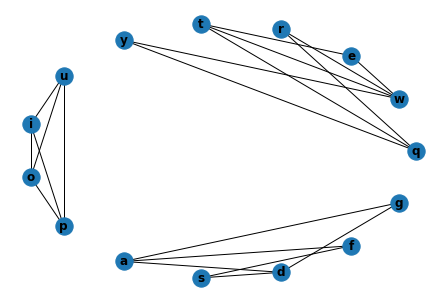

In [6]:
nx.draw_shell(F, with_labels=True, font_weight='bold')

In [7]:
for i in range(len(central)-1):
    F.add_edge(central[i], central[i+1])

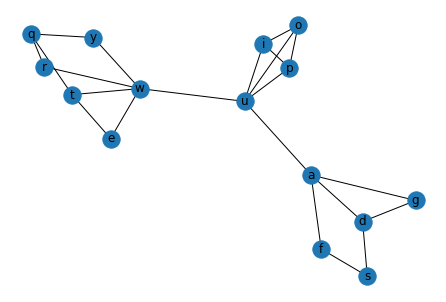

In [8]:
nx.draw(F,with_labels = True) # Final result with the three graphs linked by central nodes. 

In [9]:
#paragraph_graph_export.txt


## Extracting graphs from text files
We create a function that makes the neccesary steps to create a single chain graph per document. This function allows us to choose a document and it will output the corresponding graph. 

In [130]:
def graph_generator(text_file,document,ParagraphNumber):
    my_file = open(text_file, "r")
    content = my_file.read()
    ContnetList = content.split("Document id: ")
    #document = 0 # range(len(ContnetList)-1) <-------------------
    doc_graph = pd.DataFrame()
    doc_id = []
    pragraph_level = ContnetList[document+1].split("==========================================") # For the frist
    Number_of_paragraphs = len(pragraph_level)-2  # Last empty row and final element -2
    for paragraph in range(Number_of_paragraphs):
        data = pragraph_level[paragraph].split('\n')
        while '' in data:
            data.remove('')
        if paragraph==0:
            doc_id.append(data[0])
            data.remove(data[0]) 
        doc_graph = pd.concat([doc_graph, pd.DataFrame(data)], ignore_index=True, axis=1)

    node=0 # initialize variables-------------------------------------------
    EdgeOrNode = 1 # 0 is paragraph id , 1 is nodes, 2 is edges 
    #Number_of_paragraphs
    #ParagraphNumber = 1
    # Cycle all id node and edges 
    nodes = []
    edges =[]
    for EdgeOrNode in range(3):
        if EdgeOrNode == 0:
            P_id = doc_graph[ParagraphNumber][EdgeOrNode].split('Term: ')#[node+1]
            P_id = P_id[0][-1:]
        elif EdgeOrNode == 1:
            for node in range(len(doc_graph[ParagraphNumber][EdgeOrNode].split('Term: '))-1):
                nodes.append(doc_graph[ParagraphNumber][EdgeOrNode].split('Term: ')[node+1])
        elif EdgeOrNode == 2: 
            edges = doc_graph[ParagraphNumber][EdgeOrNode].split('Term: ')[0][36:-1]
            edges = ast.literal_eval(edges)
    # Create a graph for the paragraph ------------------------
    G = nx.Graph()
    G.graph['Paragraph_id'] = P_id
    G.graph['Doc_id'] = doc_id[0]
    for node_n in range(len(nodes)):  # Add nodes 
        N_ = nodes[node_n].split(', ')
        G.add_node(N_[0], w = float(N_[1][8:-3]))
    #nx.draw(G,with_labels = True)
    for i in range(len(list(edges.keys()))): # Add edges
        G.add_edge(list(edges.keys())[i][0],list(edges.keys())[i][1], weight = edges[list(edges.keys())[0]])
    #nx.draw(G,with_labels = True)
    return G,Number_of_paragraphs,doc_id
def GraphFromText(Text_file,document_number):# 
    N_parapgraphs = graph_generator("paragraph_graph_export_weights.txt",document_number,1)[1]
    Graphs = [graph_generator("paragraph_graph_export_weights.txt",document_number,i)[0] for i in range(N_parapgraphs)]
    doc_id=graph_generator("paragraph_graph_export_weights.txt",document_number,1)[2]
    return Graphs,doc_id

def central_node(G): # Compute central node 
    b = nx.betweenness_centrality(G)
    L = list(b.keys())
    return L[np.argmax(np.array([b[i] for i in L])) ]

def ComposeFull(L): # Link into a single graph 
    F = nx.Graph()
    central = []
    for g in L:
        F = nx.compose(F,g)
        central.append(central_node(g))
    for i in range(len(central)-1):
        F.add_edge(central[i], central[i+1])
    return F

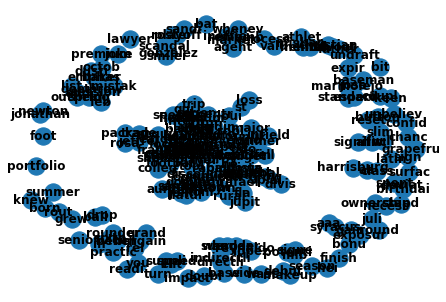

In [133]:
Document = 0 # Choose a document 
Graphs, doc_id = GraphFromText("paragraph_graph_export_weights.txt",Document)
document_graph = ComposeFull(Graphs)
nx.draw(document_graph, with_labels=True, font_weight='bold')

This result has too many separated components. Therefore, we use the largest connected component as our document graph. The size of the components decreases fast, in our case we can see that the second component has 6 nodes, and the next component has four, thus we can expect this largest component to be the most important given the connections it has. 

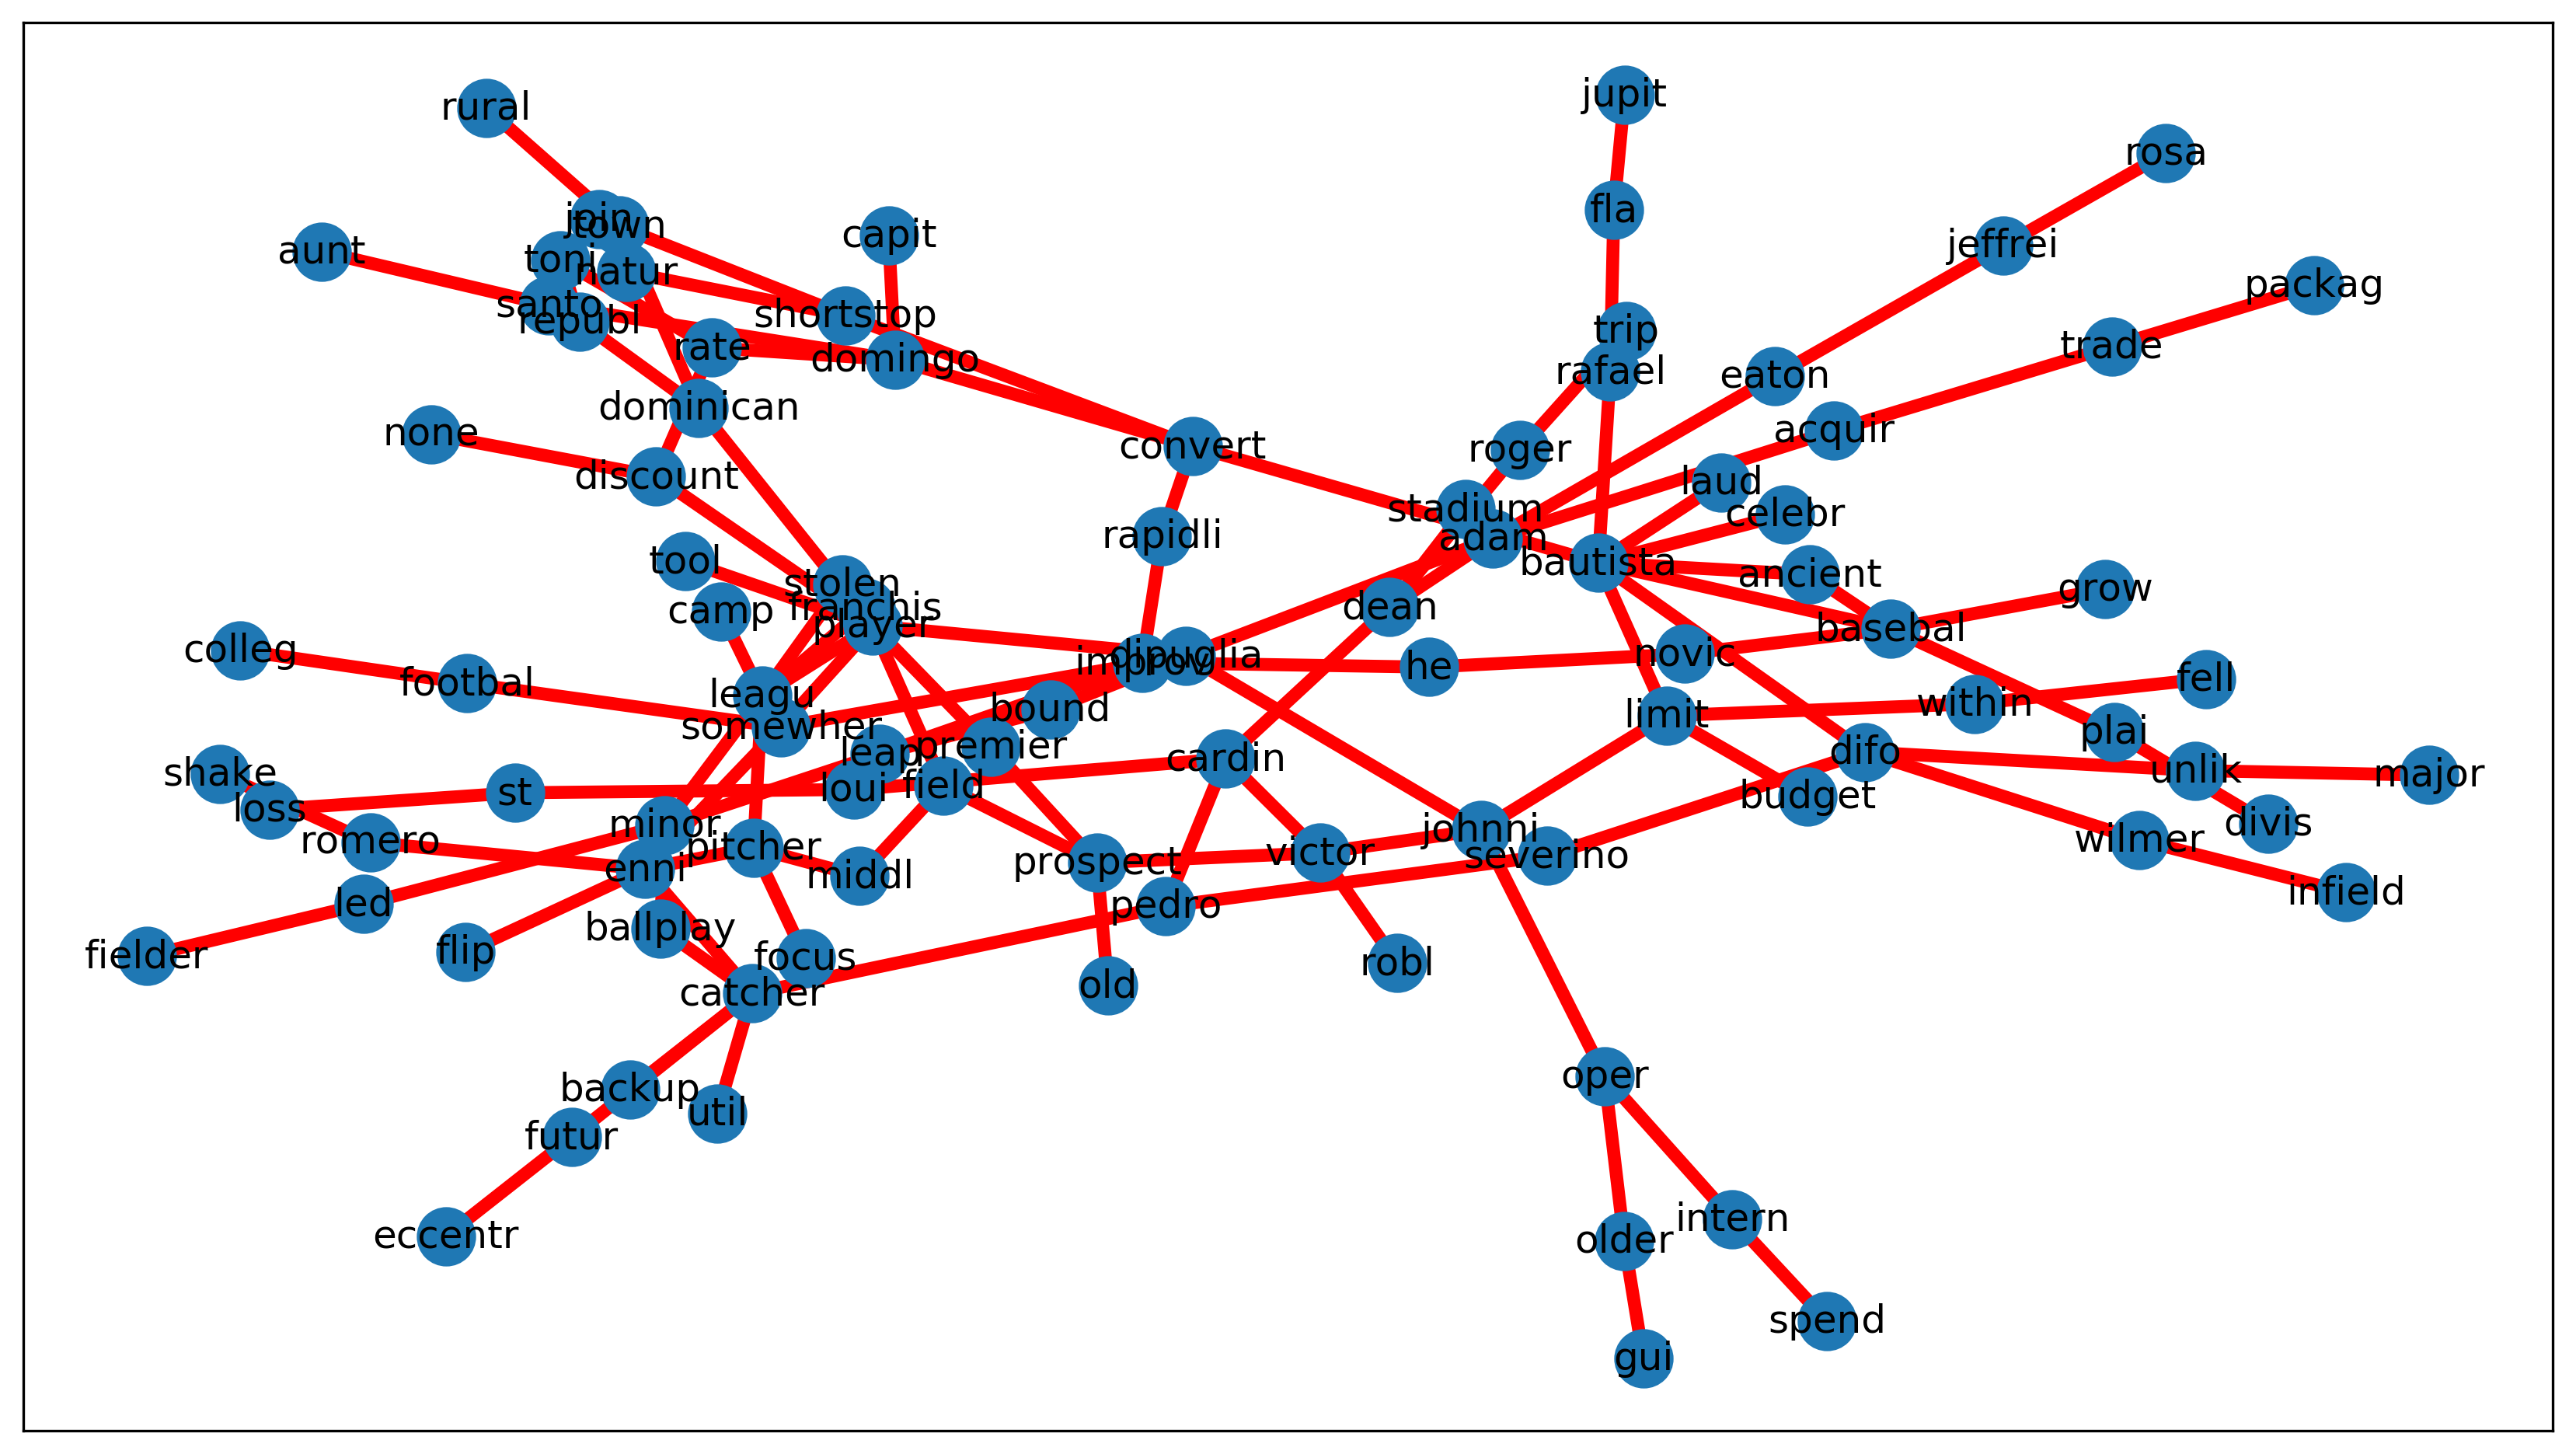

In [100]:
Gcc = sorted(nx.connected_components(document_graph), key=len, reverse=True)
G0 = document_graph.subgraph(Gcc[0])
pos =  nx.spring_layout(document_graph)
figure(num=None, figsize=(14, 8), dpi=300, facecolor='w', edgecolor='k')
nx.draw_networkx(G0,pos, edge_color="r", width=4.0)

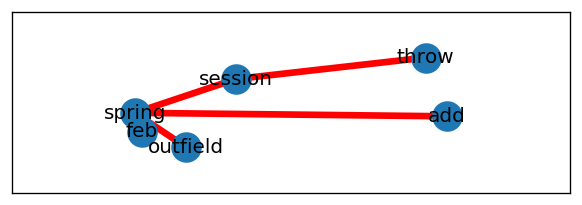

In [101]:
G1 = document_graph.subgraph(Gcc[1])
pos =  nx.spring_layout(document_graph)
figure(num=None, figsize=(6,2), dpi=120, facecolor='w', edgecolor='k')
nx.draw_networkx(G1,pos, edge_color="r", width=4.0)

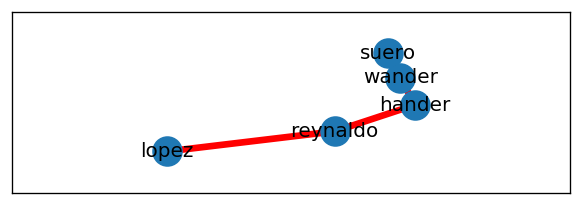

In [102]:
G2 = document_graph.subgraph(Gcc[2])
pos =  nx.spring_layout(document_graph)
figure(num=None, figsize=(6,2), dpi=120, facecolor='w', edgecolor='k')
nx.draw_networkx(G2,pos, edge_color="r", width=4.0)

## We can make it a single function 
The most relevant part of the graph is the largest connected component. We can compute it efficiently with the following funciton. 

In [140]:
def GCC_txt(TextFile, Document):
    Graphs, doc_id = GraphFromText("paragraph_graph_export_weights.txt",Document)
    document_graph = ComposeFull(Graphs)
    Gcc = max(nx.connected_components(document_graph), key=len)
    G0 = document_graph.subgraph(Gcc)
    G0.name=doc_id[0]
    return G0

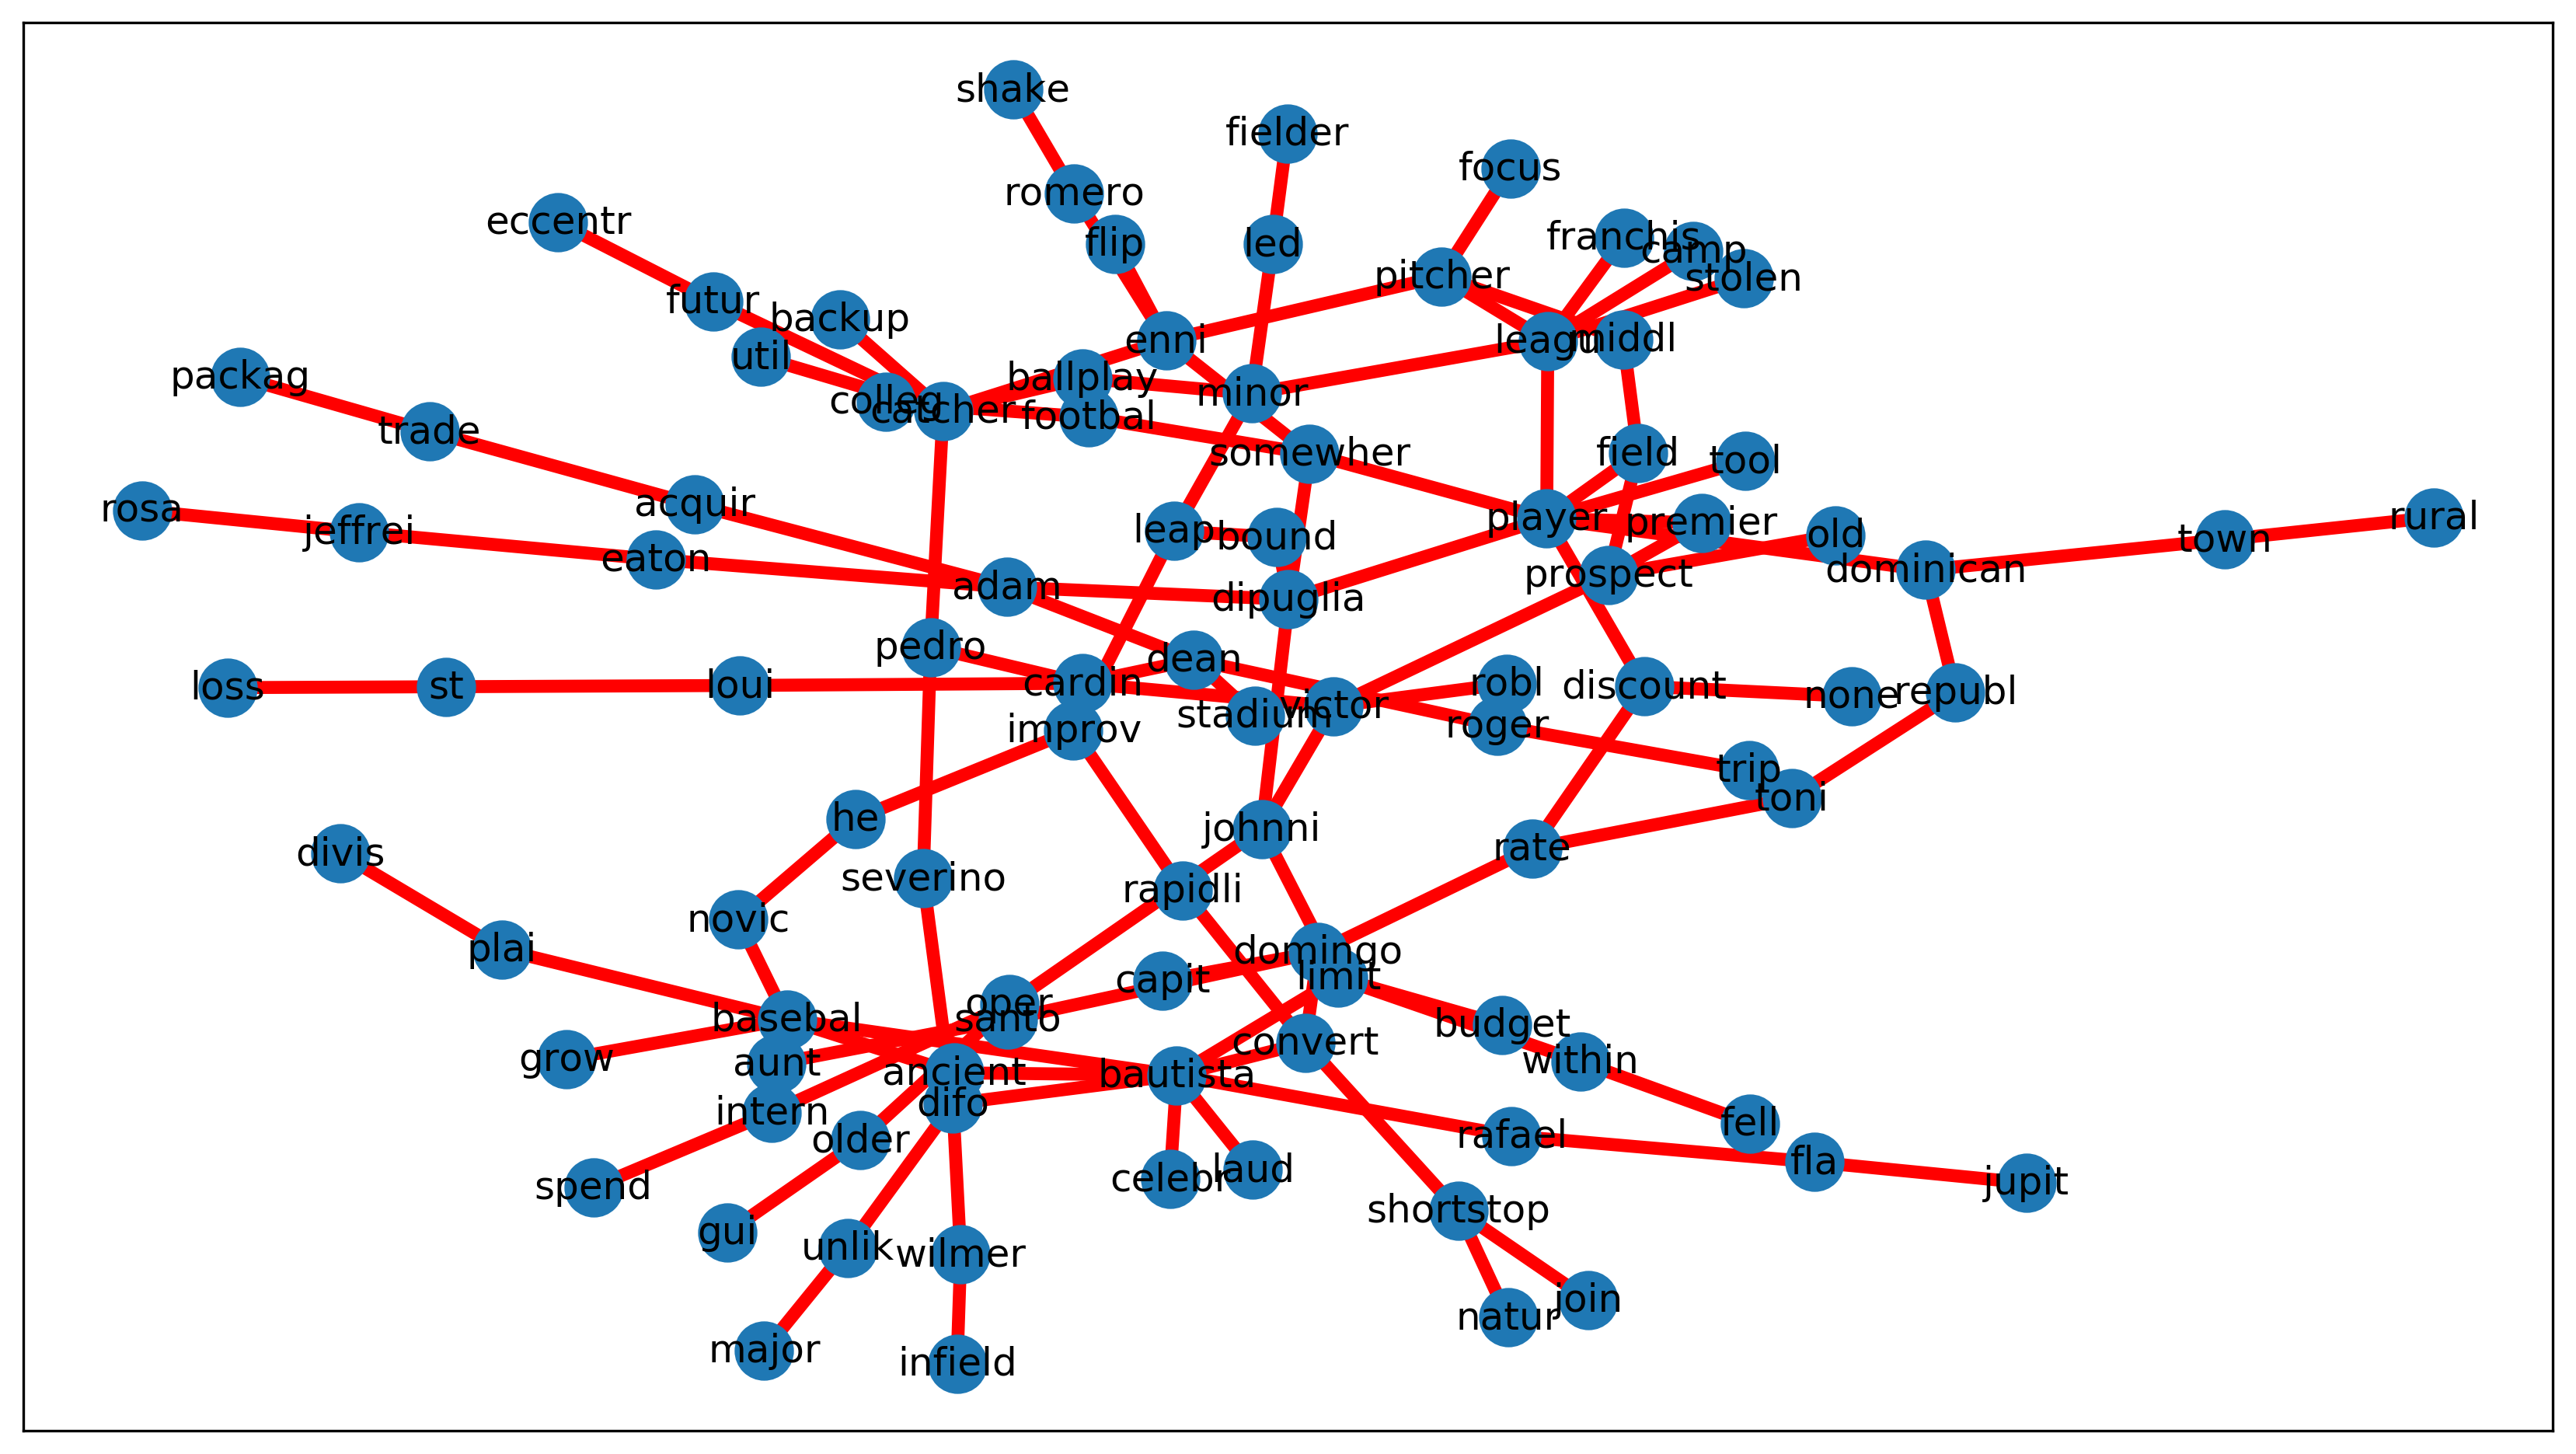

In [141]:
GCC = GCC_txt("paragraph_graph_export_weights.txt", 0)
# And then graph 
pos =  nx.spring_layout(GCC)
figure(num=None, figsize=(14,8), dpi=300, facecolor='w', edgecolor='k')
nx.draw_networkx(GCC,pos, edge_color="r", width=4.0)

In [142]:
GCC = GCC_txt("paragraph_graph_export_weights.txt", 0)

# Extracting our graph data

In [147]:
# To extract the weight of each node
print(GCC.nodes['stolen']['w'])
# And each edge
print(GCC['stolen']['leagu']['weight'])
# The document id is the name of the graph
print(GCC.name)

0.5853402216198673
0.5
1dd6be099ea95e49f4341b8e335acc30
